In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

In [2]:
import pandas as pd
import yfinance as yf
#AMZN = yf.download('CL=F', period="max", progress=False)
# AMZN = yf.download('AMZN') for all 
AMZN = pd.read_csv("1h_data.csv")
AMZN["Date"] = AMZN["Unnamed: 0"]
AMZN.set_index("Date")
AMZN.drop("Unnamed: 0", axis=1, inplace=True)
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
cut = int(len(all_data)*0.8)
start = time.time()

<AxesSubplot:>

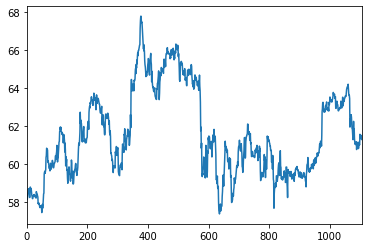

In [3]:
all_data['Adj Close'].plot()

In [4]:
print("There are "+ str(all_data[: cut].shape[0]) + " observations in the training data")
print("There are "+ str(all_data[cut:].shape[0]) + " observations in the test data")

There are 885 observations in the training data
There are 222 observations in the test data


In [5]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:cut].iloc[:,0:1].values
    ts_test  = all_data[cut:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:cut], all_data["Adj Close"][ cut :]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(879, 5)

In [6]:
# Make the 3-D shape to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,58.32,58.17,58.28,58.36,58.53,58.71,58.63
1,58.17,58.28,58.36,58.53,58.71,58.63,58.73
2,58.28,58.36,58.53,58.71,58.63,58.73,58.54
3,58.36,58.53,58.71,58.63,58.73,58.54,58.26
4,58.53,58.71,58.63,58.73,58.54,58.26,58.70
...,...,...,...,...,...,...,...
874,59.34,59.23,59.25,59.46,59.28,59.42,59.50
875,59.23,59.25,59.46,59.28,59.42,59.50,59.44
876,59.25,59.46,59.28,59.42,59.50,59.44,59.42
877,59.46,59.28,59.42,59.50,59.44,59.42,59.11


In [7]:
# Make the 3-D shape to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4
0,59.50,59.44,59.42,59.11,59.57
1,59.44,59.42,59.11,59.57,59.42
2,59.42,59.11,59.57,59.42,59.49
3,59.11,59.57,59.42,59.49,59.73
4,59.57,59.42,59.49,59.73,59.77
...,...,...,...,...,...
215,60.83,60.90,61.14,61.07,61.03
216,60.90,61.14,61.07,61.03,61.58
217,61.14,61.07,61.03,61.58,61.39
218,61.07,61.03,61.58,61.39,61.54


In [8]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 879 samples in the training data
There are 220 samples in the test data


In [9]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    name = all_data.iloc[cut].name
    actual_pred['Adj. Close'] = all_data.loc[name:,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

In [10]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:cut].iloc[:,0:1].values
    ts_test  = all_data[cut:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][: cut], all_data["Adj Close"][cut :]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)

(0.096147515, <AxesSubplot:>)

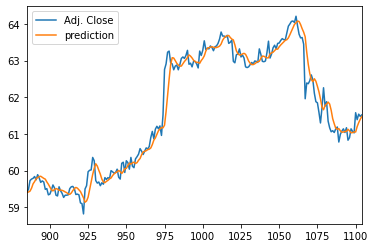

In [11]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

timing
17.901962995529175


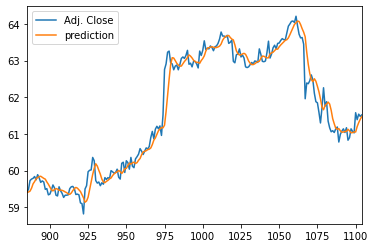

In [12]:
def GRU_model_regularization(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    from keras.layers import Dropout
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    
    # Third GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=1))
    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_predictions[1:10]
actual_pred_plot(GRU_prediction)

end = time.time()
print("timing")
print((end - start))

In [13]:
result = GRU_prediction[:,0]   
    
f= open("1h-pred-gru.txt","w")

for i in range(0,len(result)):
    f.write(str(result[i]) +",")    

f.close()

In [14]:
print(len(result))

220
